# ANDROID
## Validacion de espectrograma y modelo
#### Luciano De Bortoli | Ingeniería de Sonido
<img src="logo.jpg" alt="Drawing" align="left" style="width: 300px;"/>

In [1]:
from ..scripts import validationTools

Using TensorFlow backend.


Para adaptar las funciones de python (paquete librosa) en android, es necesario reescribirlas en JAVA. Una vez hecho esto, se debe validar que los cómputos por ambos métodos sean iguales.

## PYTHON VS JAVA
Primero se compara el espectrograma obtenido utilizando las funciones de librosa, con el espectrograma obtenido usando las funciones traducidas a JAVA, (usando Eclipse). En estos casos el espectrograma tiene un rango de -80 a 0 dB.
Esto se hace para:
* una señal chirp de 3 segundos (20 Hz a 20 kHz)
* un señal ambiental de audio proveniente del dataset TUT.
* una señal de diente de sierra sintetizada por código.

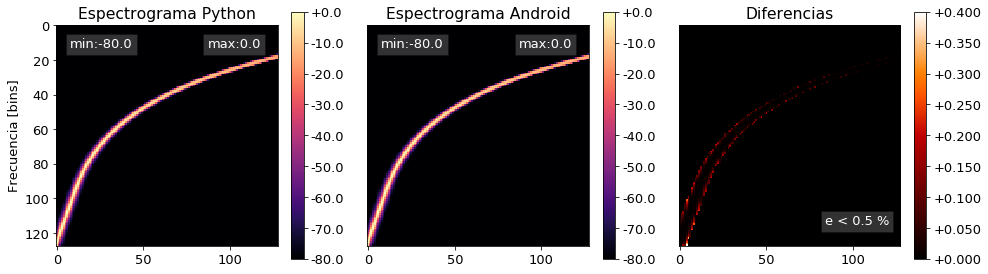

In [119]:
# chirp usada con funciones de JAVA (usando eclipse) y PYTHON. 
python_spectrogram, android_spectrogram = validationTools.get_spectrograms(
    python_path="validation_data\\chirpSignal.wav",
    python_type='audio_wav',
    android_path="validation_data\\chirpSpectrogram.csv",
    android_type='spec_csv')
validationTools.plot_differences(python_spectrogram, android_spectrogram,figname="chirp_reference")

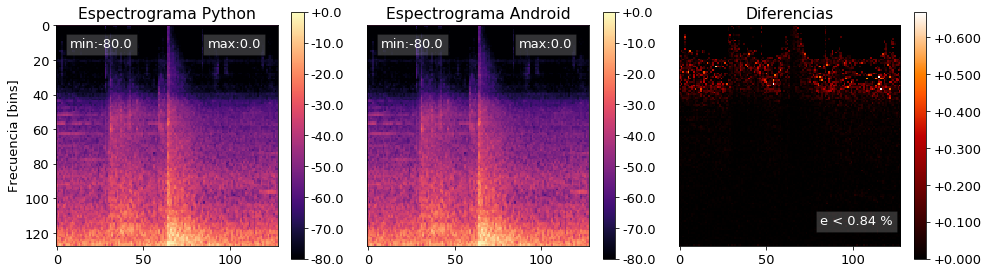

In [126]:
# audio ambiental usado con funciones de JAVA (usando eclipse) y PYTHON. 
python_spectrogram, android_spectrogram = validationTools.get_spectrograms(
    python_path="validation_data\\metroMelSpec.wav",
    python_type='audio_wav',
    android_path="validation_data\\metroMelSpec.csv",
    android_type='spec_csv'
)
validationTools.plot_differences(python_spectrogram, android_spectrogram,figname="metro_ambience")

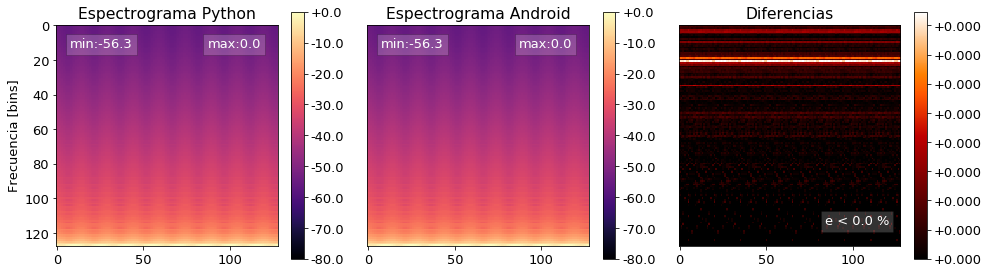

In [127]:
# señal generada en python por un lado, y JAVA por otro. Comparacion de respectivos espectrogramas.
sawtooth_signal = validationTools.generate_signal(function=sawtooth)
python_spectrogram, android_spectrogram = validationTools.get_spectrograms(
    python_path=sawtooth_signal,
    python_type='audio_array',
    android_path="validation_data\\signalAndroidSawtooth.csv",
    android_type='audio_csv'  
)
plot_differences(python_spectrogram, android_spectrogram,figname="sawtooth",)

## PYTHON VS ANDROID
Luego se verifica que funcione en Android, sobre una señal chirp que es registrada por el micrófono del celular. Las señales y los espectrogramas (128x128) se exportan a csv para realizar las comparaciones en python. En estas pruebas, el espectrograma se encuentra normalizado entre 0 y 1.

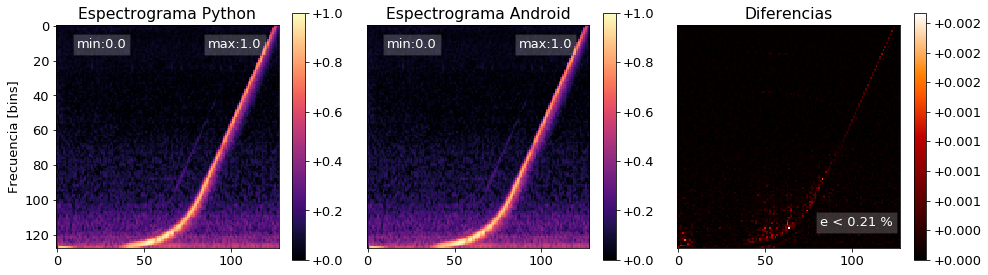

In [128]:
# comparación de logChirp. audio grabado con celular. y espectrograma obtenido con ANDROID vs PYTHON.
python_spectrogram, android_spectrogram = validationTools.get_spectrograms(
    python_path='validation_data\\chirpLogsignal.csv',
    python_type='audio_csv',
    android_path="validation_data\\chirpLogspectrogram.csv",
    android_type='spec_csv',
    normalize_python=True
)
validationTools.plot_differences(
    python_spectrogram,
    android_spectrogram,
    figname="chirpLog_signal",
    normalized=True
)

Se verifica en todos los casos que el espectrograma obtenido tiene diferencias menores al 0.5%.

## TENSORFLOW VS TENSORFLOW LITE

Una vez validado el espectrograma, es necesario validar el modelo de TensorFlow Lite adaptado en Android.
La metodología consiste en comparar las predicciones obtenidas en TensorFlow Lite con las obtenidas por el modelo de Keras.
Para ello, se importa el modelo.

In [5]:
import os
classifier = validationTools.load_model("C:\\Users\\Luciano\\Documents\\Jupyter\\TESIS\\main\\models\\CNN_final_DA_butter_92.hdf5")
labels = os.listdir("J:\\DataOffline\\Datasets\\COMBINATIONS\\COMBI_FINAL_MELSPECTROGRAM")

Se exportan a csv los audios y las predicciones sobre señales capturadas a través de la aplicacion Android, en una escena sonora de habitación, silenciosa, y haciendo ruidos sobre una mesa.

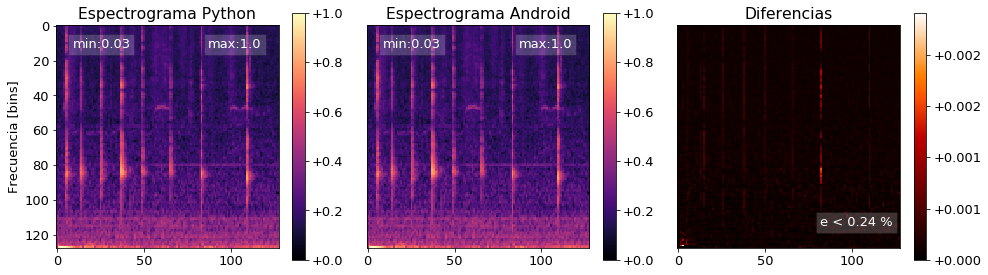

In [3]:
# comparación de home tapping. audio y espectrograma obtenido con android.
python_spectrogram, android_spectrogram = validationTools.get_spectrograms(
    python_path='validation_data\\homesignal.csv',
    python_type='audio_csv',
    android_path="validation_data\\homespectrogram.csv",
    android_type='spec_csv',
    normalize_python=True
)
validationTools.plot_differences(
    python_spectrogram,
    android_spectrogram,
    figname="home_signal",
    normalized=True,
)

Prediction Difference<  0.01 %


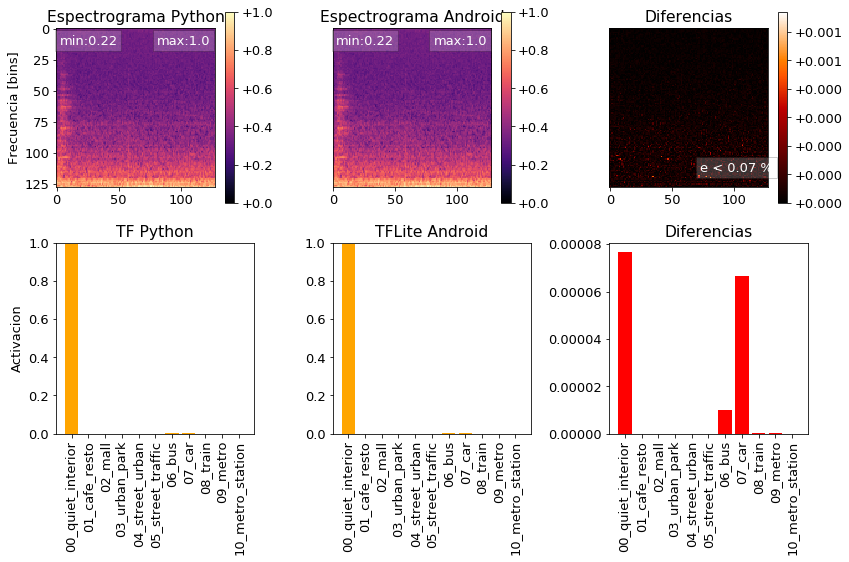

In [23]:
# validacion tensorflow Lite
python_spectrogram, android_spectrogram = validationTools.get_spectrograms(
    python_path="validation_data\\123209_home val_signal.csv",
    python_type='audio_csv',
    android_path="validation_data\\123209_home val_spectrogram.csv",
    android_type='spec_csv',
    normalize_python=True,
    normalize_android=False,
)
validationTools.plot_differences(
    python_spectrogram,
    android_spectrogram,
    model = classifier,
    labels = labels,
    normalized=True,
    figname="tensorflowLite_val",
    android_predictions = "validation_data\\123209_home val_predictions.csv"
)

Se verifica que las diferencias entre las predicciones obtenidas por el modelo de TensorFlow y TensorFlow Lite son menores al 0.001 %. De esta manera, quedan validados todos los procesos de señal en la aplicación. El espectrograma y las predicciones obtenidas con la aplicación dependen entonces solamente del proceso de captura de la señal de audio.

Threshold set to:  0.17
Threshold set to:  0.17
Prediction with no Compression:  07_car
Prediction with Compression:  00_quiet_interior


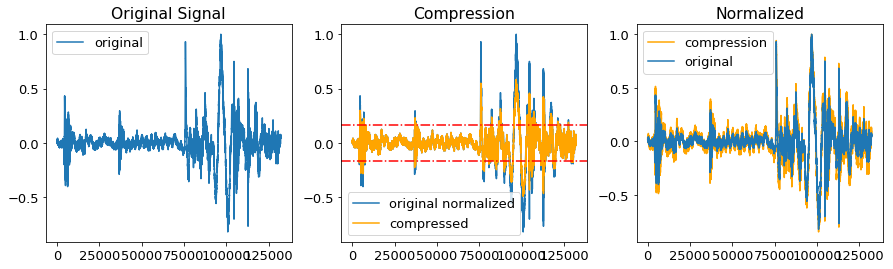

In [156]:
# MOTO (home signal) * experimentos implementando compresión en el audio. [no se utiliza finalmente]
audio = validationTools.load_audio_csv("validation_data\\moto_home_bad_pred.csv")
validationTools.compare_compression(audio_array,model=classifier,labels=labels)

El audio se registra en android a través de la clase AudioRecord. Que permite obtener muestras a 48kHz, 32 bit float.
Las muestras se encuentran definidas en el rango (-1.0,1.0). Las amplitudes de las muestras dependen del sonido ambiente y de las características del micrófono principal utilizado por el dispositivo móvil. La señal registrada puede diferir caso a caso, por lo que se experimenta con técnicas de compresión de rango dinámico, aunque no son implementadas en la aplicacion final. 

In [ ]:
# comparación de no compression vs compression para un falso positivo de home.
audio = validationTools.load_audio_csv("validation_data\\home_test_signall21_06.csv")
compressed=validationTools.normalize_audio(validationTools.compressor(validationTools.normalize_audio(audio)))
python_spectrogram, android_spectrogram = validationTools.get_spectrograms(
    python_path=audio,
    python_type='audio_array',
    android_path=compressed,
    android_type='audio_array',
    normalize_python=True,
    normalize_android=True
)
validationTools.plot_differences(
    python_spectrogram,
    android_spectrogram,
    model = classifier,
    labels = labels,
    normalized=True,
    figname="uncompressed_vs_compressed",
)